In [1]:
from transformers import AutoModelForObjectDetection
model = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-detection", revision="no_timm")
print(model.config.id2label)

/Users/bhairavjain/Desktop/building_object_detection_module/venv_pdf_object/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{0: 'table', 1: 'table rotated'}


In [2]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print("")

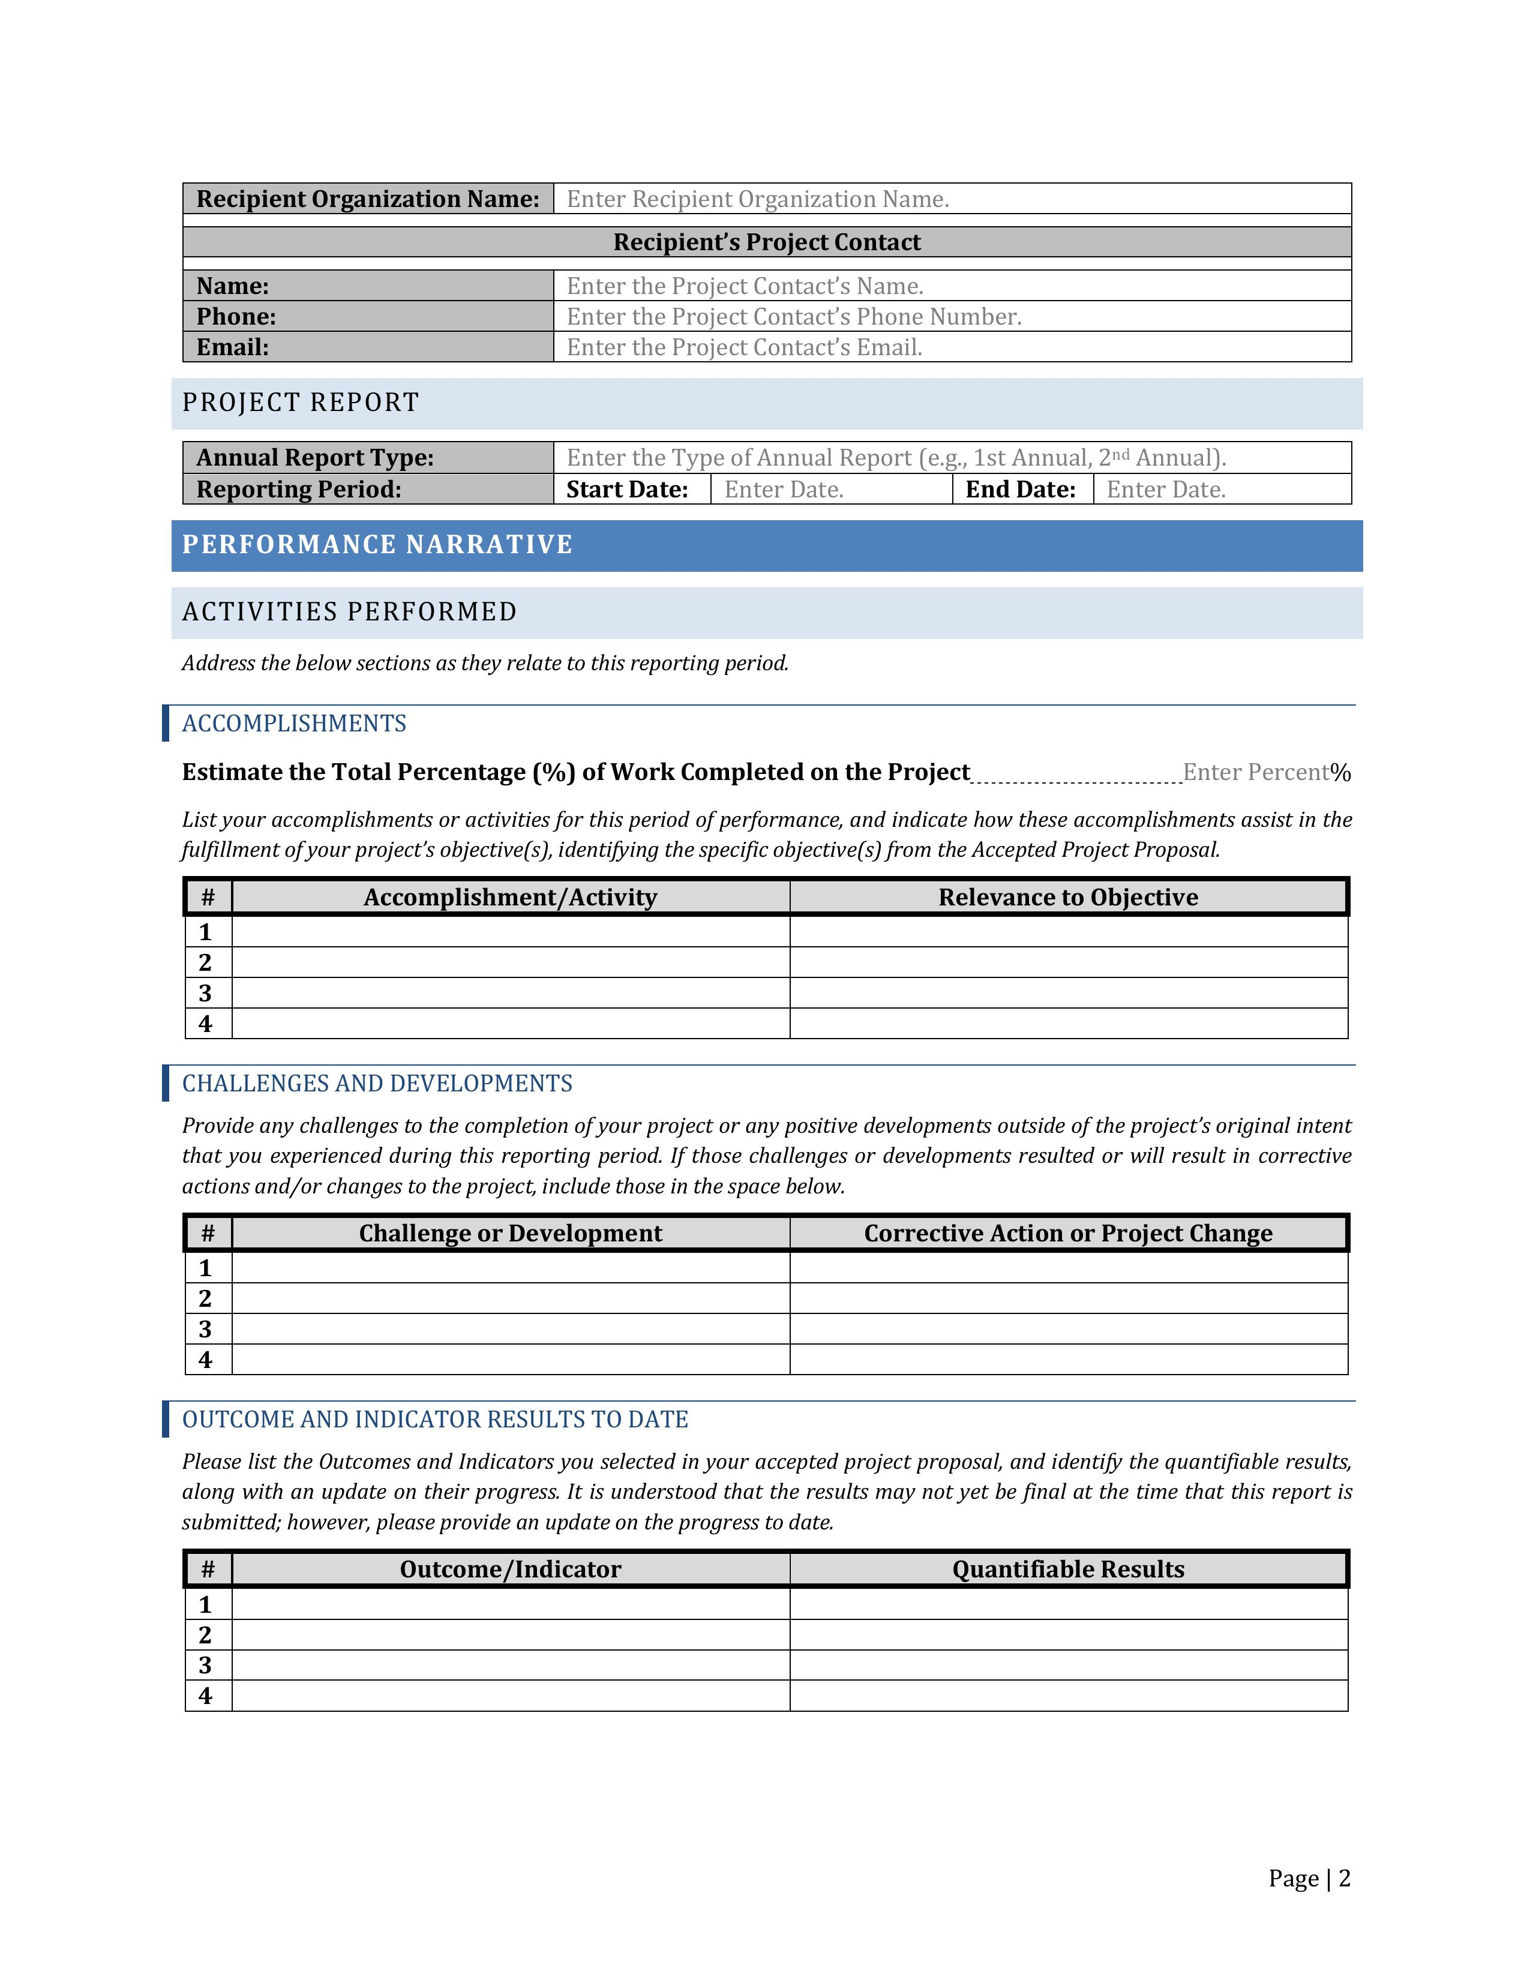

In [3]:
from PIL import Image
from huggingface_hub import hf_hub_download

# let's load an example image
file_path = '/Users/bhairavjain/Desktop/building_object_detection_module/pdf_query_document/pdf_ouptut/Annual-Report-Template/images/image1.jpeg'
image = Image.open(file_path).convert("RGB")
# let's display it a bit smaller
width, height = image.size
display(image.resize((int(0.6*width), (int(0.6*height)))))

In [4]:
from torchvision import transforms

class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize((int(round(scale*width)), int(round(scale*height))))

        return resized_image

detection_transform = transforms.Compose([
    MaxResize(800),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

pixel_values = detection_transform(image).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 800, 618])


In [5]:
import torch

with torch.no_grad():
  outputs = model(pixel_values)

print(outputs.logits.shape)

torch.Size([1, 15, 3])


In [6]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


# update id2label to include "no object"
id2label = model.config.id2label
id2label[len(model.config.id2label)] = "no object"


def outputs_to_objects(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == 'no object':
            objects.append({'label': class_label, 'score': float(score),
                            'bbox': [float(elem) for elem in bbox]})

    return objects

objects = outputs_to_objects(outputs, image.size, id2label)
print(objects)

[{'label': 'table', 'score': 0.8149338364601135, 'bbox': [314.18682861328125, 2067.5126953125, 2108.72021484375, 2300.14111328125]}, {'label': 'table', 'score': 0.9928994178771973, 'bbox': [317.60693359375, 2607.061767578125, 1977.862548828125, 2855.20361328125]}, {'label': 'table', 'score': 0.9885439276695251, 'bbox': [298.44830322265625, 1475.13623046875, 2007.1396484375, 1737.4727783203125]}, {'label': 'table', 'score': 0.5142120122909546, 'bbox': [318.1671142578125, 377.8082580566406, 2009.54638671875, 808.4431762695312]}]


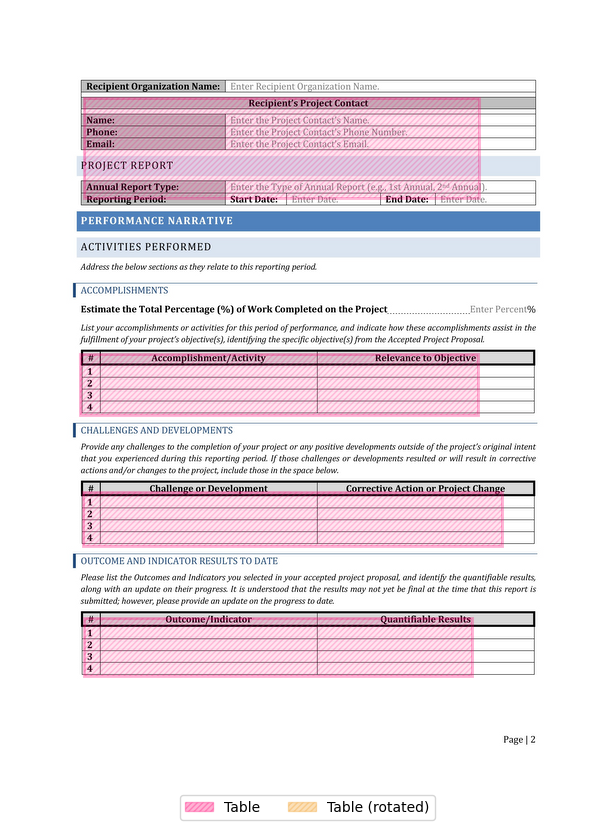

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img


def visualize_detected_tables(img, det_tables, out_path=None):
    plt.imshow(img, interpolation="lanczos")
    fig = plt.gcf()
    fig.set_size_inches(20, 20)
    ax = plt.gca()

    for det_table in det_tables:
        bbox = det_table['bbox']

        if det_table['label'] == 'table':
            facecolor = (1, 0, 0.45)
            edgecolor = (1, 0, 0.45)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        elif det_table['label'] == 'table rotated':
            facecolor = (0.95, 0.6, 0.1)
            edgecolor = (0.95, 0.6, 0.1)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        else:
            continue

        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth,
                                    edgecolor='none',facecolor=facecolor, alpha=0.1)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth,
                                    edgecolor=edgecolor,facecolor='none',linestyle='-', alpha=alpha)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=0,
                                    edgecolor=edgecolor,facecolor='none',linestyle='-', hatch=hatch, alpha=0.2)
        ax.add_patch(rect)

    plt.xticks([], [])
    plt.yticks([], [])

    legend_elements = [Patch(facecolor=(1, 0, 0.45), edgecolor=(1, 0, 0.45),
                                label='Table', hatch='//////', alpha=0.3),
                        Patch(facecolor=(0.95, 0.6, 0.1), edgecolor=(0.95, 0.6, 0.1),
                                label='Table (rotated)', hatch='//////', alpha=0.3)]
    plt.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.02), loc='upper center', borderaxespad=0,
                    fontsize=10, ncol=2)
    plt.gcf().set_size_inches(10, 10)
    plt.axis('off')

    if out_path is not None:
      plt.savefig(out_path, bbox_inches='tight', dpi=150)

    return fig

fig = visualize_detected_tables(image, objects)
visualized_image = fig2img(fig)

In [10]:
from PyPDF2 import PdfReader, PdfWriter

In [13]:
source_pdf_file_path = r'/Users/bhairavjain/Desktop/research_paper/Annual_Report___2022_23__2__bWICfx.pdf'
out_folder = r'/Users/bhairavjain/Desktop/research_paper'
pdf_reader = PdfReader(source_pdf_file_path)
pages = [(87,87)]
for page_indices in pages:
    pdf_writer = PdfWriter()  # we want to reset this when starting a new pdf
    for idx in range(page_indices[0] - 1, page_indices[1]):
        pdf_writer.add_page(pdf_reader.pages[idx])
    # output_filename = f"{out_folder}/{source_pdf_file_path.stem}_{page_indices[0]}.pdf"
    output_filename = out_folder + "/Annual_Report___2022_23__2__bWICfx_87.pdf"
    with open(output_filename, "wb") as out:
        pdf_writer.write(out)